## Generative models should preserve relative distances from input to latent to generated space
- Read in model and some n input images
- Using L1 (others later), find distance between image pairs
- Transform to latent space and output space, again measuring L1 at both stages
- Do analysis

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning
from pytorch_lightning import Trainer
from dataloader import Dataset
import os
import vae
from model import Model
import simplejson 
import math
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage as pil
from torchvision.utils import make_grid
from PIL import Image
from IPython.display import display

### Setup
#### Read in data

#### Read in model

In [2]:
exs = [
    '/home/sonia/generative-models/logs/dists/mnist/vae/version_0', # (0)
    '/home/sonia/generative-models/logs/dists/gtsrb/vae/version_0', # (1)
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_0', #128 latent dims (2)
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_1', #32 latent dims (3)
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_2', #8 latent dims (4)
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_3', # 32 latent dims evolution (5)
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_4', # 8 latent dims evolution (6)
    '/home/sonia/generative-models/logs/dists/celeba/betavae/version_0', # (7)
]

In [3]:
path_to_model = exs[7]
n = 100
# the epoch for which you want to use the checkpoint, or -1 to use the last checkpoint
epoch = 79

In [4]:
modelconfig = simplejson.load(open(os.path.join(path_to_model, 'modelconfig.json')))
dataconfig = simplejson.load(open(os.path.join(path_to_model, 'dataconfig.json')))
if epoch == -1:
    print('Will use checkpoint last.ckpt')
    checkpoint = os.path.join(path_to_model, 'checkpoints/last.ckpt')
else:
    d = os.listdir(os.path.join(path_to_model, 'checkpoints')) # epoch=0....ckpt, epoch=1....ckpt, ...., last.ckpt
    checkpoint_name = [ckpt for ckpt in d if ckpt.startswith(f'epoch={epoch}-')][0]
    print('Will use checkpoint', checkpoint_name)
    checkpoint = os.path.join(path_to_model, f'checkpoints/{checkpoint_name}')
model = vae.vanilla_vae(**modelconfig['model_params']).cuda()

# declaring these objects initializes some important things that cause images to look correct - do not remove
experiment = Model(model.cuda(), modelconfig['exp_params']).cuda()
e=experiment.load_from_checkpoint(checkpoint, model=model, params=modelconfig['exp_params'])
trainer = Trainer(gpus=[0])

Will use checkpoint epoch=20-step=53424.ckpt


/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


STOP - do you mean to run the next block?

Files already downloaded and verified
Files already downloaded and verified


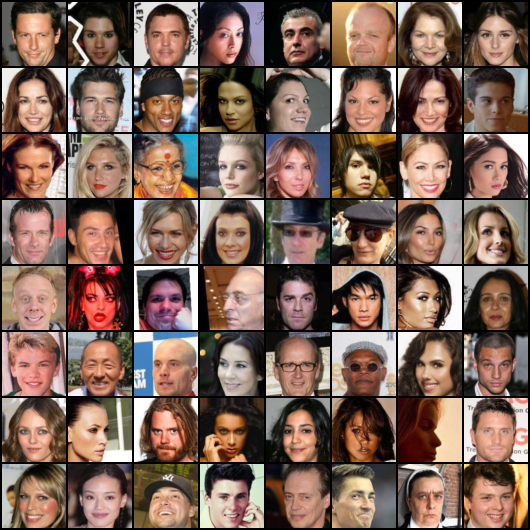

In [5]:
data = Dataset(**dataconfig, pin_memory=True)#use GPU
data.setup()
val = data.val_dataset

#choose random subset of n samples
randy = torch.rand(size=(len(val), ))
indices = [i.item() for i in torch.topk(randy, n)[1]] #actual index numbers
inputdata = torch.utils.data.Subset(val, indices)
input = DataLoader(inputdata, 
                    batch_size=dataconfig['val_batch_size'],
                    num_workers=dataconfig['num_workers'],
                    shuffle=False,
                    pin_memory=True)

batch=next(iter(input))
imgs = batch[0]
pil()(make_grid(imgs, nrow=int(imgs.shape[0]**0.5)))
# to get index: the top row has indices 0, 1, 2, etc

In [6]:
index = 20 # which image in the batch that you want to look at
factor = 150 #how far from mean to move, ie e^factor

### Evaluate

In [7]:
## #### (Optional) run on all train and validation data to compare metrics
# val dataset
# trainer.test(model=experiment, dataloaders=data.val_dataloader())
# train dataset
# trainer.test(model=experiment, dataloaders=data.train_dataloader())

#### Transform to latent and output spaces

In [8]:
# for visualization
def normalize(v):
    v = v-v.min()
    v = v/v.max()
    return v

In [9]:
# for distribution graphs
o = []
i = []
mu = []
logvar = []
model=model.cuda()

for b, x in input:
    res = model.forward(b.cuda())
    logvar.append(res[3])
    i.append(b)
    mu.append(res[2])
    o.append(res[0])

o=torch.cat(o).cpu().detach().numpy()
i=torch.cat(i).cpu().detach().numpy()
mu = torch.cat(mu).cpu().detach().numpy()
logvar = torch.cat(logvar).cpu().detach().numpy()
var = math.e**logvar

In [10]:
# https://stackoverflow.com/questions/23186804/graph-point-on-straight-line-number-line-in-python
def graph(mu, var):
    # set up the figure
    upper = (mu+var**.5).max() + 0.01
    lower = (mu-var**.5).min() - 0.01
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(lower, upper)
    ax.set_ylim(0,10)

    # draw lines
    xmin = lower
    xmax = upper
    y = 5
    height = 1

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)
    plt.text(xmin, y-1, '%.2f'%lower, horizontalalignment='left')
    plt.text(xmax, y-1, '%.2f'%upper, horizontalalignment='right')
    if lower < 0 and upper > 0:
        plt.vlines(0, y - height / 2., y + height / 2.)
        plt.text(0, y-1, '0', horizontalalignment='center')

    for i in range(len(mu)):
        plt.plot(mu[i], y, 'go', ms = 20*var[i]**.5, mfc = 'g', alpha=0.5)

    plt.axis('off')
    plt.show()

NOTE: The standard deviations aren't to-scale relative to the rest of the graph, only to each other. This is an issue of matplotlib, will probably need to revisit later.

0
Dimension 0 	mean 0.06 	var 3.06


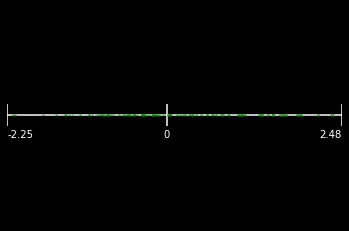

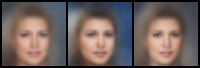

1
Dimension 1 	mean 0.06 	var 3.27


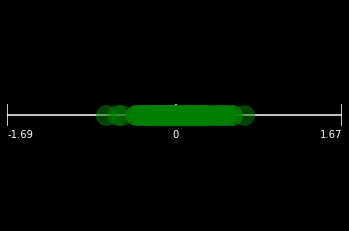

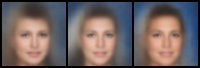

2
Dimension 2 	mean 0.01 	var 3.19


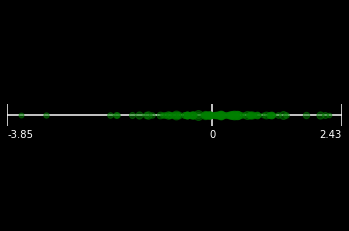

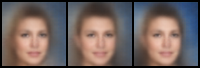

3
Dimension 3 	mean 0.10 	var 3.12


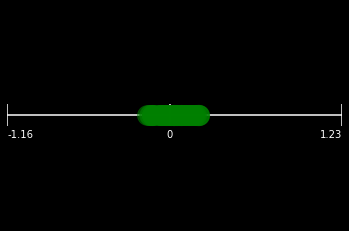

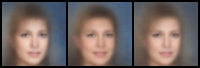

4
Dimension 4 	mean -0.23 	var 3.07


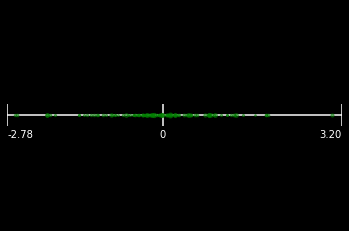

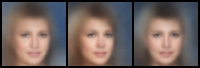

5
Dimension 5 	mean 0.03 	var 3.13


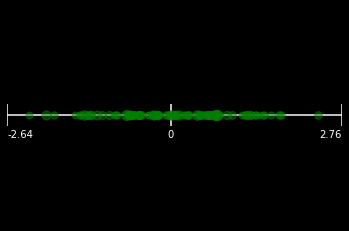

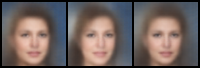

6
Dimension 6 	mean -0.08 	var 3.20


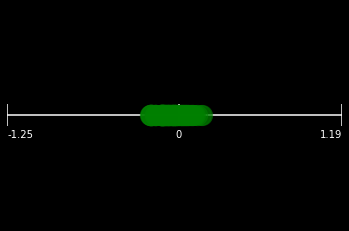

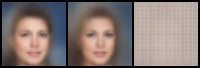

7
Dimension 7 	mean 0.27 	var 2.87


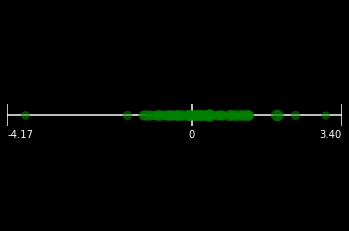

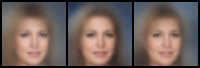

8
Dimension 8 	mean -0.20 	var 2.95


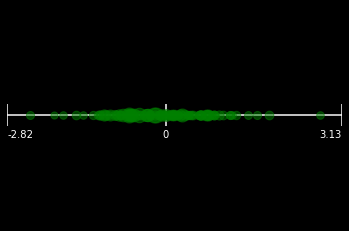

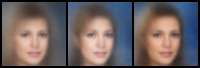

9
Dimension 9 	mean -0.25 	var 2.75


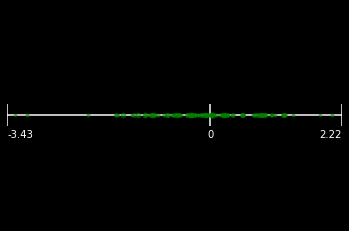

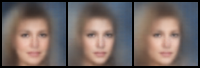

10
Dimension 10 	mean -0.07 	var 3.17


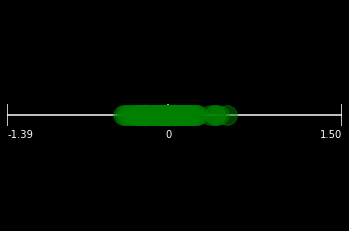

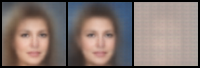

11
Dimension 11 	mean 0.52 	var 2.95


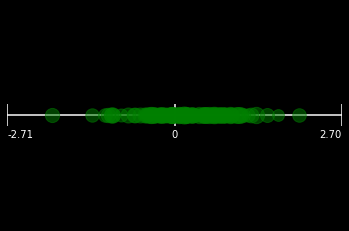

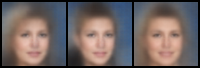

12
Dimension 12 	mean 0.20 	var 2.50


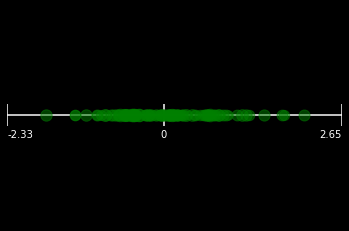

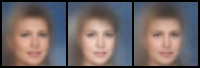

13
Dimension 13 	mean 0.70 	var 3.61


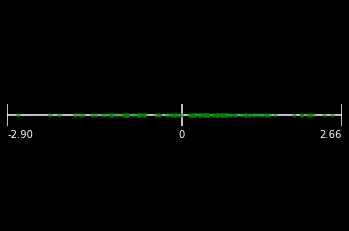

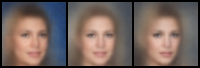

14
Dimension 14 	mean -0.11 	var 2.64


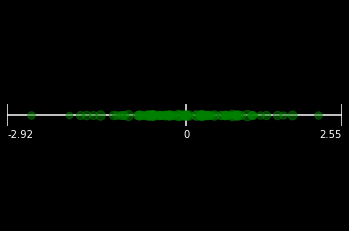

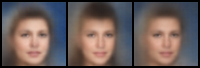

15
Dimension 15 	mean 0.06 	var 2.91


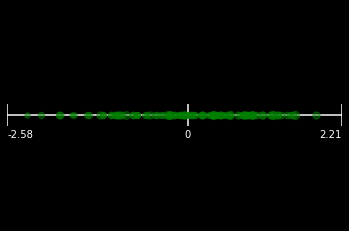

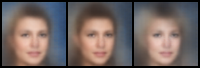

16
Dimension 16 	mean 0.46 	var 2.79


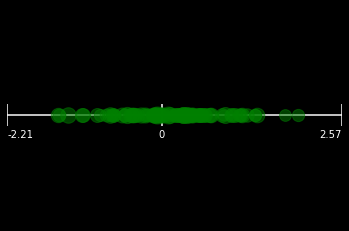

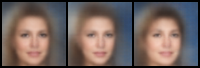

17
Dimension 17 	mean -0.17 	var 2.94


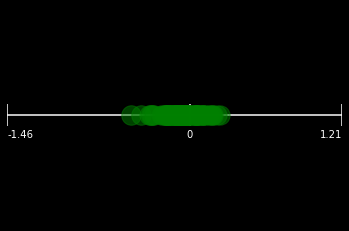

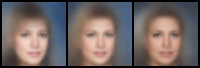

18
Dimension 18 	mean 0.26 	var 2.90


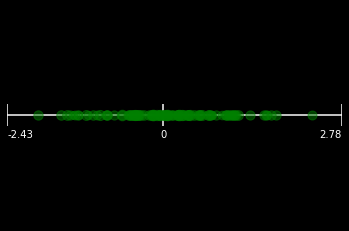

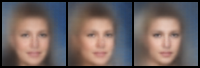

19
Dimension 19 	mean 0.11 	var 3.30


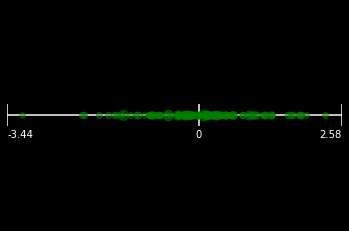

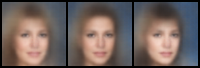

20
Dimension 20 	mean -0.02 	var 3.20


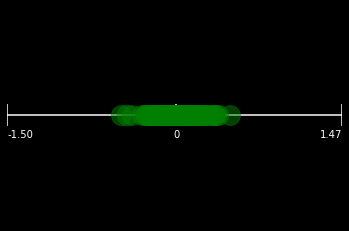

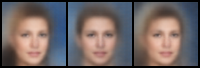

21
Dimension 21 	mean -0.14 	var 2.87


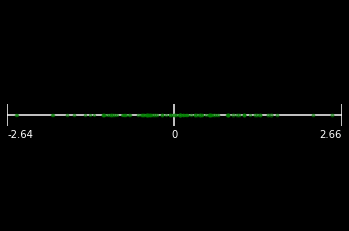

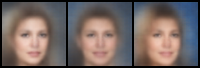

22
Dimension 22 	mean -0.13 	var 3.27


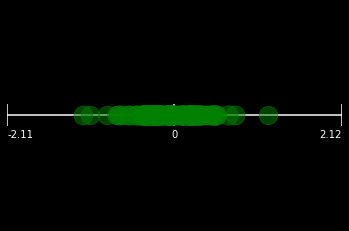

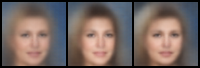

23
Dimension 23 	mean 0.20 	var 2.37


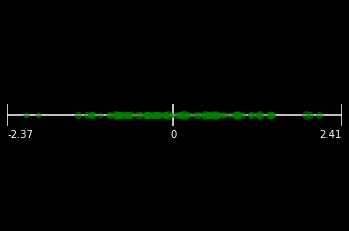

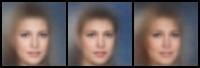

24
Dimension 24 	mean 0.28 	var 2.84


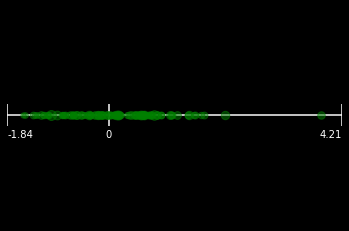

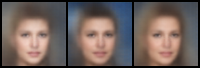

25
Dimension 25 	mean -0.10 	var 2.52


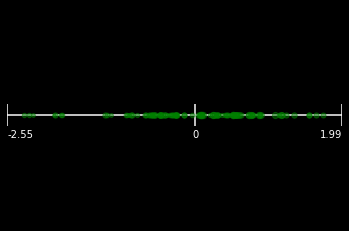

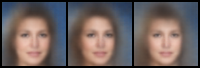

26
Dimension 26 	mean 0.18 	var 3.22


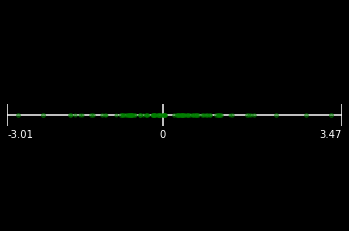

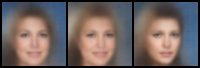

27
Dimension 27 	mean 0.01 	var 2.99


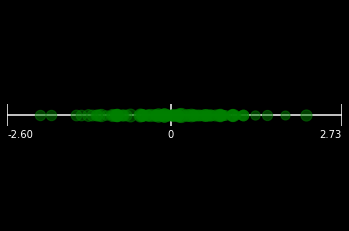

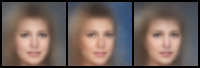

28
Dimension 28 	mean -0.48 	var 2.97


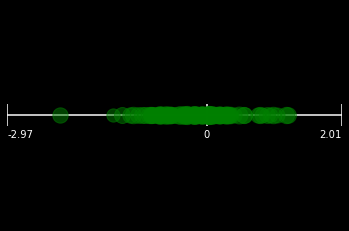

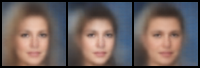

29
Dimension 29 	mean 0.15 	var 3.19


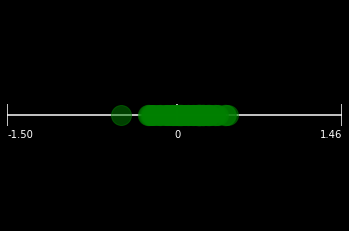

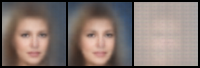

30
Dimension 30 	mean -0.07 	var 3.21


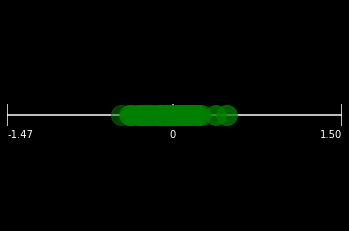

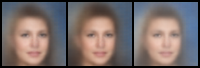

31
Dimension 31 	mean -0.20 	var 2.93


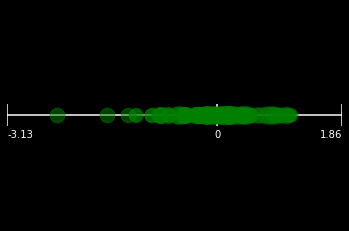

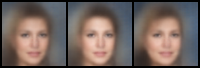

In [11]:
D=mu.shape[1]
dmeans = []
dstdevs = []
for d in range(D):
    print(d)
    mean = mu[:,d].sum()/D #mixture distribution
    stdev = (var[:,d] + mu[:,d]**2).sum()/D - mean**2
    print('Dimension', d, '\tmean %.2f'%mean, '\tvar %.2f'%stdev)
    graph(mu[:,d], var[:,d])
    dmeans.append(mean)
    dstdevs.append(stdev)

    o, i, bmu, blogvar = model.forward(imgs.cuda())
    o = normalize(o)[index].squeeze()

    mup = bmu
    mup[:,d] = mup[:,d] + math.e**(factor*blogvar[:,d])
    op = model.decode(model.reparameterize(mup, blogvar))
    op = normalize(op)[index].squeeze()

    mum = bmu
    mum[:,d] = mum[:,d] - math.e**(factor*blogvar[:,d])
    om = model.decode(model.reparameterize(mum, blogvar))
    om = normalize(om)[index].squeeze()

    grid = make_grid([om, o, op])
    display(pil()(grid))

Mean and stdev tend to be about 0 and 1?

In [12]:
sum(dmeans)/D

0.04360324973822571

In [13]:
sum(dstdevs)/D

2.9964655073479296

Ideas
- Compare shape of dimension's distribution for train vs val set
- How does all this change with different quantities of data and numbers of latent dimensions
- Over course of training, hypothesis that mean and stdev for each dimension tend to tend closer to 0 and 1 respectively
- For betavae: find a dimension corresponding to some underrepresented attribute and see how it differs from one corresponding to a well-represented attribute
- ***What do we WANT these graphs to look like??***
    - Find a model we *know* is bad, what's it look like? (evolution over training)
    - A good model would look similar on val as it does on train set
    - More data = better?
    - Anything in literature?
    - -> Lets us find when or in which respects a model is good

### How distributions evolve over time

In [14]:
edmu = [] # epoch's distributions' means average
edsd = [] # epoch's distributions' standard deviations average
model=model.cuda()
d = os.listdir(os.path.join(path_to_model, 'checkpoints')) # epoch=0....ckpt, epoch=1....ckpt, ...., last.ckpt
for epoch in range(len(d)-1):
    checkpoint_name = [ckpt for ckpt in d if ckpt.startswith(f'epoch={epoch}-')][0]
    checkpoint = os.path.join(path_to_model, f'checkpoints/{checkpoint_name}')
    
    o = []
    i = []
    mu = []
    logvar = []

    for b, x in input:
        res = model.forward(b.cuda())
        logvar.append(res[3])
        i.append(b)
        mu.append(res[2])
        o.append(res[0])

    o=torch.cat(o).cpu().detach().numpy()
    i=torch.cat(i).cpu().detach().numpy()
    mu = torch.cat(mu).cpu().detach().numpy()
    logvar = torch.cat(logvar).cpu().detach().numpy()
    var = math.e**logvar

    D=mu.shape[1]
    dmeans = []
    dstdevs = []
    for dim in range(D): # get distrib info for each dimension
        mean = mu[:,dim].sum()/D #mixture distribution
        stdev = (var[:,dim] + mu[:,dim]**2).sum()/D - mean**2
        dmeans.append(mean)
        dstdevs.append(stdev)
    edmu.append(sum(dmeans)/D)
    edsd.append(sum(dstdevs)/D)

Text(0, 0.5, 'dimensional mean mean')

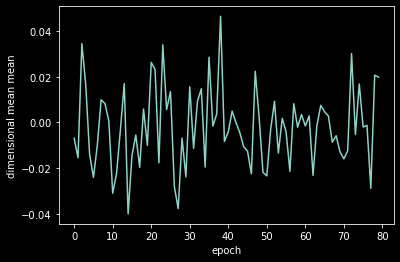

In [15]:
plt.plot(range(len(edmu)), edmu)
plt.xlabel("epoch")
plt.ylabel("dimensional mean mean")

Text(0, 0.5, 'dimensional mean standard deviation')

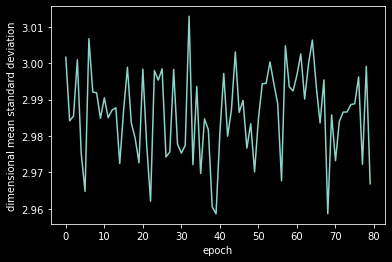

In [16]:
plt.plot(range(len(edsd)), edsd)
plt.xlabel("epoch")
plt.ylabel("dimensional mean standard deviation")